In [37]:
import numpy as np
# import optbinning
import pandas as pd
import sklearn.linear_model
import sklearn.preprocessing
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

# from yc_younipy.metrics.model.roc_auc import gini_computation as gini
from sklearn.metrics import make_scorer, roc_auc_score
import optbinning
import matplotlib.pyplot as plt
import pathlib
from sklearn.compose import ColumnTransformer


from alibi_detect.cd import ChiSquareDrift, TabularDrift
from alibi_detect.utils.saving import save_detector, load_detector
import seaborn as sns

In [24]:
! head attribute_information.txt

date time year-month-day hour:minute:second 
Temperature, in Celsius 
Relative Humidity, % 
Light, in Lux 
CO2, in ppm 
Humidity Ratio, Derived quantity from temperature and relative humidity, in kgwater-vapor/kg-air 
Occupancy, 0 or 1, 0 for not occupied, 1 for occupied status

### Conclusion: Pay attention to humidity ratio, as it is the only derived quantity

In [25]:
features_covariate = ["Temperature",  "Humidity", "Light", "CO2", "HumidityRatio"]

# ETL

In [31]:
df = pd.read_csv("datatraining.txt", index_col=0)
df = df.sort_values(by=['date'])
df.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
1,2015-02-04 17:51:00,23.18,27.2720,426.0,721.25,0.004793,1
2,2015-02-04 17:51:59,23.15,27.2675,429.5,714.00,0.004783,1
3,2015-02-04 17:53:00,23.15,27.2450,426.0,713.50,0.004779,1
4,2015-02-04 17:54:00,23.15,27.2000,426.0,708.25,0.004772,1
5,2015-02-04 17:55:00,23.10,27.2000,426.0,704.50,0.004757,1


In [32]:
df.isna().sum()

date             0
Temperature      0
Humidity         0
Light            0
CO2              0
HumidityRatio    0
Occupancy        0
dtype: int64

In [33]:
df.dtypes

date              object
Temperature      float64
Humidity         float64
Light            float64
CO2              float64
HumidityRatio    float64
Occupancy          int64
dtype: object

In [34]:
print(df["date"].min())
print(df["date"].max())

2015-02-04 17:51:00
2015-02-10 09:33:00


## Temporal target distribution

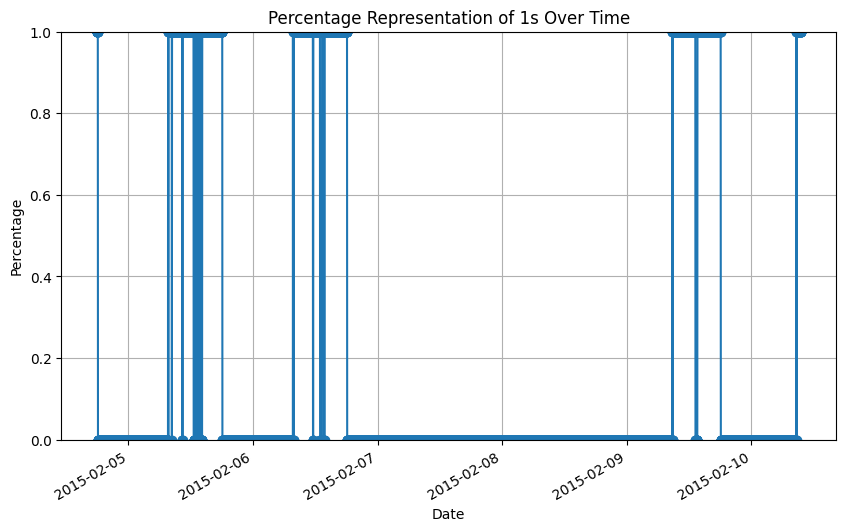

In [7]:
df['date'] = pd.to_datetime(df['date'])

# Calculate the percentage representation of 1s for each date
percentage_representation = df.groupby('date')['Occupancy'].mean()

# Plot the percentage representation over time
plt.figure(figsize=(10, 6))
percentage_representation.plot(marker='o')
plt.title('Percentage Representation of 1s Over Time')
plt.xlabel('Date')
plt.ylabel('Percentage')
plt.ylim(0, 1)  # Set y-axis limits to 0 and 1 for percentage representation
plt.grid(True)
plt.show()

## Correlation matrix

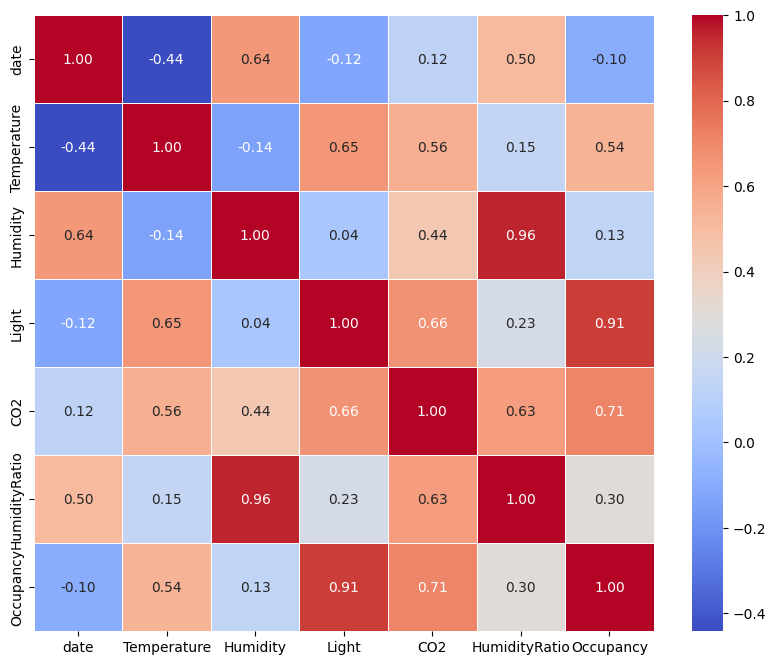

In [11]:
# Calculate the correlation matrix
correlation_matrix = df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Create a heatmap with Seaborn
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)

# Show the plot
plt.show()

In [16]:
def pearson_correlation(X):
    data = X
    corr_pearson = data.corr(method='pearson')
    plt.subplots(figsize=(15,10))
    sns.heatmap(corr_pearson)
    # drop correlated feature
    # Return a new array of given shape and type, filled with fill_value.
    columns = np.full((corr_pearson.shape[0],), True, dtype=bool) 
    for i in range(corr_pearson.shape[0]):
        for j in range(i+1, corr_pearson.shape[0]):
            if corr_pearson.iloc[i,j] >= 0.75:
                if columns[j]:
                    columns[j] = False
    selected_columns_pearson = data.columns[columns]
    return selected_columns_pearson, corr_pearson

def spearman_correlation(X):
    data = X
    corr_spearman = data.corr(method='spearman')
    plt.subplots(figsize=(15,10))
    sns.heatmap(corr_spearman, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
    # Returns a new array of given shape and type, filled with fill_value.
    columns = np.full((corr_spearman.shape[0],), True, dtype=bool) 
    for i in range(corr_spearman.shape[0]):
        for j in range(i+1, corr_spearman.shape[0]):
            if corr_spearman.iloc[i,j] >= 0.75:
                if columns[j]:
                    columns[j] = False
    selected_columns_spearman = data.columns[columns]
    return selected_columns_spearman, corr_spearman

(Index(['date', 'Temperature', 'Humidity', 'Light', 'CO2'], dtype='object'),
                    date  Temperature  Humidity     Light       CO2  \
 date           1.000000    -0.453814  0.634367 -0.073193 -0.033000   
 Temperature   -0.453814     1.000000 -0.193389  0.565237  0.636906   
 Humidity       0.634367    -0.193389  1.000000  0.007065  0.223519   
 Light         -0.073193     0.565237  0.007065  1.000000  0.473103   
 CO2           -0.033000     0.636906  0.223519  0.473103  1.000000   
 HumidityRatio  0.452875     0.104765  0.940327  0.169057  0.378357   
 Occupancy     -0.098155     0.532830  0.129235  0.804645  0.656651   
 
                HumidityRatio  Occupancy  
 date                0.452875  -0.098155  
 Temperature         0.104765   0.532830  
 Humidity            0.940327   0.129235  
 Light               0.169057   0.804645  
 CO2                 0.378357   0.656651  
 HumidityRatio       1.000000   0.255836  
 Occupancy           0.255836   1.000000  )

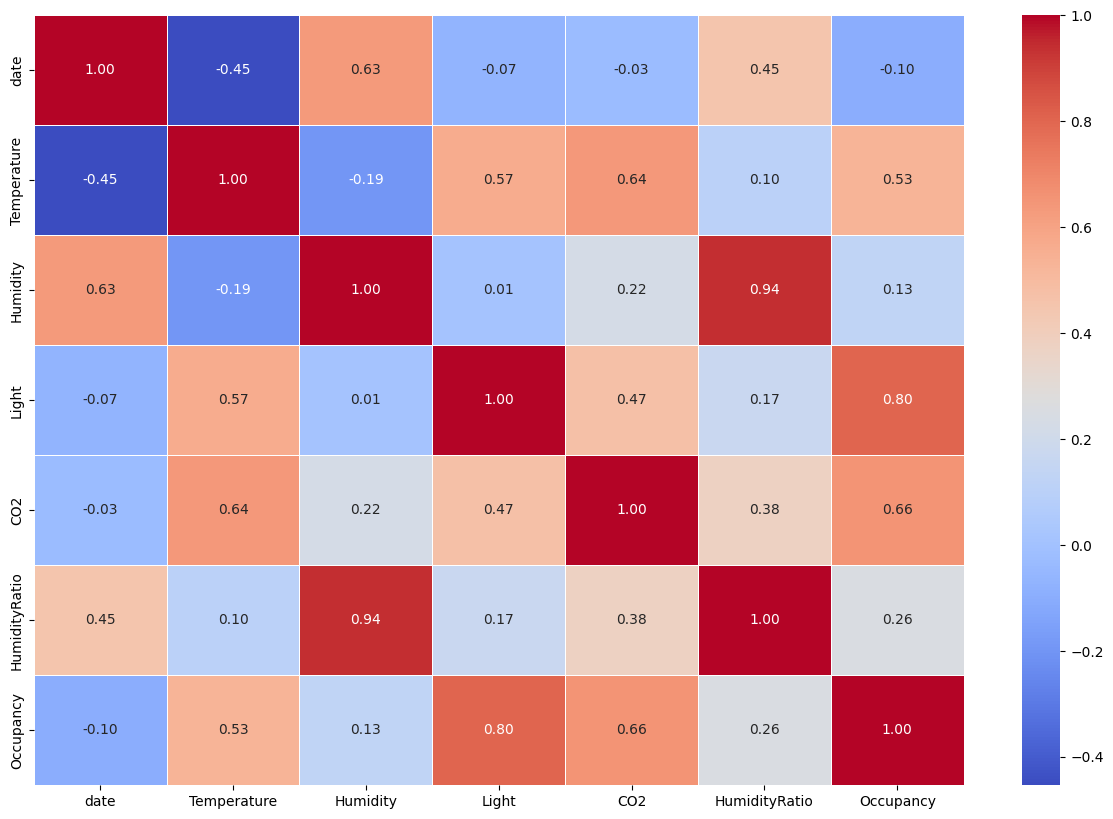

In [18]:
spearman_correlation(df)

### Conclusion: 
- Occupancy is highly correlated with light and a little to CO2.
- Temperature is slightly correlated with CO2
- Humidy ratio is obviously highly correlated to humidiy 

## Extract week and hour

In [69]:
df['date_formatted'] = pd.to_datetime(df['date'], format='%Y-%m-%d %H:%M:%S')

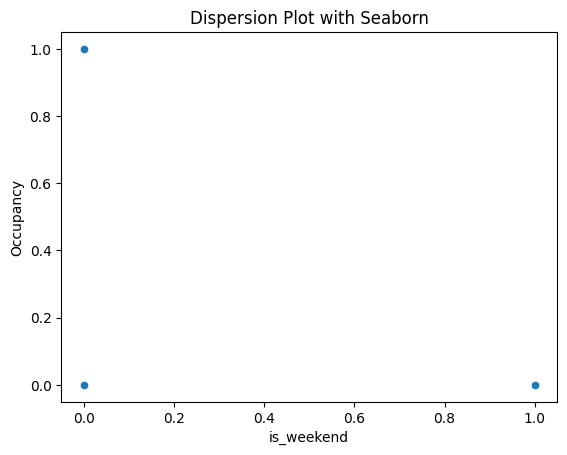

In [72]:
# Extract day of the week (Monday is 0 and Sunday is 6)
df['is_weekend'] = df['date_formatted'].dt.dayofweek // 5 == 1
sns.scatterplot(x='is_weekend', y='Occupancy', data=df)
plt.title('Dispersion Plot with Seaborn')
plt.show()

In [73]:
# Extract the hour
df['hour'] = df['date_formatted'].dt.hour

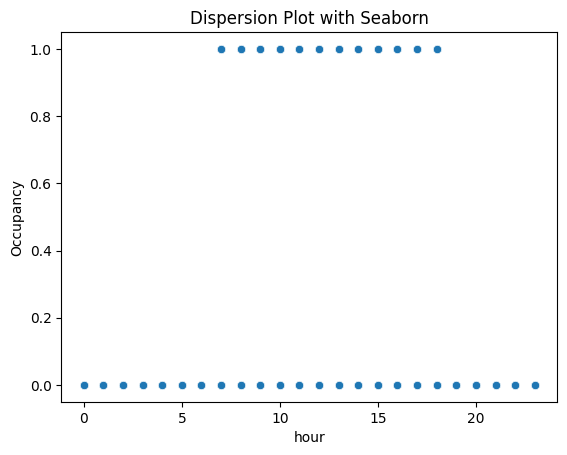

In [74]:
sns.scatterplot(x='hour', y='Occupancy', data=df)
plt.title('Dispersion Plot with Seaborn')
plt.show()

## Definition of X and y

In [41]:
X_train = df[features_covariate].copy()
y_train = df["Occupancy"].copy()

# Cross validation

## Utils functions

In [42]:
def is_notebook() -> bool:
    try:
        shell = get_ipython().__class__.__name__
        if shell == "ZMQInteractiveShell":
            return True  # Jupyter notebook or qtconsole
        elif shell == "TerminalInteractiveShell":
            return False  # Terminal running IPython
        else:
            return False  # Other type (?)
    except NameError:
        return False  # Probably standard Python interpreter


def compute_global_figures(X, target):
    df = (
        pd.Series(
            {
                "contracts": int(X["contract_reference"].count()),
                "contracts with target": int(X[target].count()),
                "defaults": int(X[target].sum()),
                "default rate": X[target].mean(),
                "beg": X["application_date"].min().date(),
                "last with target": X.loc[~X[target].isna(), "application_date"].max().date(),
                "end": X["application_date"].max().date(),
            }
        )
        .to_frame()
        .T
    )
    return df.style.format(
        {
            "default rate": "{:.2%}",
        },
        thousands=",",
    )

def pprint_dataframe(X, **kwargs):
    if is_notebook():
        from IPython.display import display

        display(X)
    else:
        kwargs.setdefault("showindex", "never")
        kwargs.setdefault("headers", "keys")
        kwargs.setdefault("tablefmt", "psql")
        kwargs.setdefault("floatfmt", ".4f")
        kwargs.setdefault("intfmt", ",")
        if isinstance(X, pd.io.formats.style.Styler):
            X = X.data
        print(tabulate.tabulate(X, **kwargs))

In [43]:
# local functions
def print_cross_validation(cv):
    """
    prints cross-validation results in a dataframe, e.g. gini, brier, std...
    @param cv: cross-validation object
    @return: dataframe with relevant statistics
    """
    sort_key = f"mean_test_{cv.refit}" if isinstance(cv.refit, str) else "mean_test_score"

    df = (
        pd.json_normalize(cv.cv_results_["params"])
        .assign(
            **{
                f"{prefix}_{step}_{metric}": cv.cv_results_[f"{prefix}_{step}_{metric}"]
                for metric in cv.scoring
                for prefix in ("mean", "std")
                for step in ("test",)
            }
        )
        .sort_values(sort_key, ascending=False)
    )
    df["clf"] = df["clf"].apply(lambda clf: clf.version)
    try:
        df = df[~df["mean_test_auc"].isna()]
    except KeyError:
        df = df

    try:

        def apply_style(df):
            return (
                df.style.background_gradient(
                    axis=1,
                    vmin=0,
                    vmax=df["mean_test_roc_auc"].max(),
                    subset="mean_test_roc_auc",
                    # cmap=YC_PINKS,
                )
                .format(precision=4)
                .hide(axis="index")
            )

        pprint_dataframe(apply_style(df))
        pprint_dataframe(
            apply_style(
                df.groupby("clf", as_index=False).first().sort_values(f"mean_test_{selection_metric}", ascending=False)
            )
        )
    except KeyError:
        df = df
    return df

In [44]:
class FlattenTransformer(sklearn.base.TransformerMixin, sklearn.base.BaseEstimator):
    """
    This class is used in order to create the features used for model candidate v3
    - fit method is a dummy method.
    - transform is used for the features creation.
    """

    def __init__(self):
        self._is_fitted = False

    def fit(self, X, y=None):
        self._is_fitted = True
        return self

    def set_output(self, *, transform=None):
        self._is_set_output = True
        return self

    def transform(self, X_input, y=None):
        # Return the transformed DataFrame
        return X


In [59]:
clf_v3_optb_logit = sklearn.pipeline.Pipeline(
    steps=[
        (
            "encoder",
            optbinning.BinningProcess(
                variable_names=features_covariate,
                # categorical_variables=v3_cat_features,
                max_pvalue=0.05,
            ),
        ),
        # ("removing_features_with_low_variance", VarianceThreshold(threshold=0.01)),
        ("scaler", sklearn.preprocessing.StandardScaler()),
        # ('feature_selection', feature_selector),
        (
            "logistic",
            sklearn.linear_model.LogisticRegression(random_state=0),
        ),
    ]
)
clf_v3_optb_logit.version = "v3.1-optb-logit"


clf_rf = sklearn.pipeline.Pipeline(
    steps=[
        # (
        #     "encoder",
        #     optbinning.BinningProcess(
        #         variable_names=features_covariate,
        #         # categorical_variables=v3_cat_features,
        #         max_pvalue=0.05,
        #     ),
        # ),
        # # ("removing_features_with_low_variance", VarianceThreshold(threshold=0.01)),
        # ("scaler", sklearn.preprocessing.StandardScaler()),
        # # ('feature_selection', feature_selector),
        (
            "forest",
            RandomForestClassifier(random_state=0),
        ),
    ]
)
clf_rf.version = "rf_classifier"


# grid of hyperparameters to be tested
grid = [
    {
        "clf": [clf_v3_optb_logit],
        # "clf__encoder__binning_fit_params": { [None, 0.01, 0.02, 0.03, 0.04, 0.05]},
        # "clf__logistic__C": [0.01, 0.03, 0.1, 0.3, 1],
        "clf__logistic__C": np.logspace(-3, 1, 10),  # np.linspace(0.001, 1, 10), # np.logspace(-3, 1, 5),
        "clf__logistic__solver": ["saga"],
        "clf__logistic__penalty": ["l1", "l2"],  # "elasticnet"],
        # "clf__logistic__l1_ratio": [0.0, 0.01, 0.1, 0.2, 0.5, 0.8, 1.0],
        "clf__logistic__max_iter": [5000],
    },
    {
        "clf": [clf_rf],
        "clf__forest__n_estimators": [50, 100, 200],  # Add RandomForest hyperparameters
        "clf__forest__max_depth": [None, 10, 20],
        "clf__forest__min_samples_split": [2, 5, 10],
        "clf__forest__min_samples_leaf": [1, 2, 4],
    },
]

## CV run 

In [60]:
# Cross validation object definition and fit
selection_metric = "roc_auc"
cv = sklearn.model_selection.GridSearchCV(
    estimator=sklearn.pipeline.Pipeline(steps=[("clf", clf_v3_optb_logit)]),
    param_grid=grid,
    scoring={
        "neg_log_loss": "neg_log_loss",
        "roc_auc": "roc_auc",
        "brier": "neg_brier_score",
    },
    # cv=sklearn.model_selection.TimeSeriesSplit(n_splits=2),
    cv=sklearn.model_selection.StratifiedKFold(n_splits=5),
    verbose=1,
    refit=selection_metric,
    n_jobs=12,
    return_train_score=True,
)

cv.fit(X_train, y_train)

Fitting 5 folds for each of 101 candidates, totalling 505 fits
(CVXPY) Jan 14 03:32:17 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.8.3296). Expected < 9.8.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Jan 14 03:32:17 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.8.3296). Expected < 9.8.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Jan 14 03:32:18 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.8.3296). Expected < 9.8.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Jan 14 03:32:18 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.8.3296). Expected < 9.8.0. Please open a feature request on cvxpy to enable s

/home/adelchiasta/venv/venv_presence_detector2/lib64/python3.11/site-packages/optbinning/binning/binning.py:1086: RuntimeWarning: invalid value encountered in cast
  n_nonevent = np.empty(n_bins).astype(np.int64)
/home/adelchiasta/venv/venv_presence_detector2/lib64/python3.11/site-packages/optbinning/binning/binning.py:1087: RuntimeWarning: invalid value encountered in cast
  n_event = np.empty(n_bins).astype(np.int64)


(CVXPY) Jan 14 03:32:22 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.8.3296). Expected < 9.8.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Jan 14 03:32:22 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.8.3296). Expected < 9.8.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Jan 14 03:32:22 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.8.3296). Expected < 9.8.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Jan 14 03:32:22 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.8.3296). Expected < 9.8.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Jan 14 03:32:22 PM: Encounte

/home/adelchiasta/venv/venv_presence_detector2/lib64/python3.11/site-packages/optbinning/binning/binning.py:1086: RuntimeWarning: invalid value encountered in cast
  n_nonevent = np.empty(n_bins).astype(np.int64)
/home/adelchiasta/venv/venv_presence_detector2/lib64/python3.11/site-packages/optbinning/binning/binning.py:1087: RuntimeWarning: invalid value encountered in cast
  n_event = np.empty(n_bins).astype(np.int64)


(CVXPY) Jan 14 03:32:24 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.8.3296). Expected < 9.8.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Jan 14 03:32:24 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.8.3296). Expected < 9.8.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Jan 14 03:32:24 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.8.3296). Expected < 9.8.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Jan 14 03:32:24 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.8.3296). Expected < 9.8.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Jan 14 03:32:26 PM: Encounte

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('clf',
                                        Pipeline(steps=[('encoder',
                                                         BinningProcess(max_pvalue=0.05,
                                                                        variable_names=['Temperature',
                                                                                        'Humidity',
                                                                                        'Light',
                                                                                        'CO2',
                                                                                        'HumidityRatio'])),
                                                        ('scaler',
                                                         StandardScaler()),
                                                        ('logistic',
                                                         LogisticRegression(random_state=0))]))]),
             n_jobs=12,
             param_grid=[{'clf'...
                         {'clf': [Pipeline(steps=[('forest',
                                                   RandomForestClassifier(random_state=0))])],
                          'clf__forest__max_depth': [None, 10, 20],
                          'clf__forest__min_samples_leaf': [1, 2, 4],
                          'clf__forest__min_samples_split': [2, 5, 10],
                          'clf__forest__n_estimators': [50, 100, 200]}],
             refit='roc_auc', return_train_score=True,
             scoring={'brier': 'neg_brier_score',
                      'neg_log_loss': 'neg_log_loss', 'roc_auc': 'roc_auc'},
             verbose=1)

## Results and best model

clf,clf__logistic__C,clf__logistic__max_iter,clf__logistic__penalty,clf__logistic__solver,clf__forest__max_depth,clf__forest__min_samples_leaf,clf__forest__min_samples_split,clf__forest__n_estimators,mean_test_neg_log_loss,std_test_neg_log_loss,mean_test_roc_auc,std_test_roc_auc,mean_test_brier,std_test_brier
v3.1-optb-logit,0.0077,5000.0000,l2,saga,nan,nan,nan,nan,-0.0909,0.0461,0.9918,0.0148,-0.0201,0.0139
v3.1-optb-logit,0.0028,5000.0000,l2,saga,nan,nan,nan,nan,-0.1214,0.0427,0.9917,0.0148,-0.0260,0.0126
v3.1-optb-logit,0.0215,5000.0000,l2,saga,nan,nan,nan,nan,-0.0767,0.0513,0.9917,0.0147,-0.0175,0.0142
v3.1-optb-logit,0.0599,5000.0000,l2,saga,nan,nan,nan,nan,-0.0700,0.0570,0.9917,0.0147,-0.0152,0.0134
v3.1-optb-logit,0.1668,5000.0000,l2,saga,nan,nan,nan,nan,-0.0683,0.0638,0.9916,0.0149,-0.0139,0.0133
v3.1-optb-logit,0.0010,5000.0000,l2,saga,nan,nan,nan,nan,-0.1776,0.0405,0.9916,0.0148,-0.0408,0.0115
v3.1-optb-logit,0.1668,5000.0000,l1,saga,nan,nan,nan,nan,-0.0701,0.0656,0.9916,0.0146,-0.0144,0.0134
v3.1-optb-logit,0.4642,5000.0000,l2,saga,nan,nan,nan,nan,-0.0726,0.0706,0.9915,0.0150,-0.0150,0.0135
v3.1-optb-logit,0.0599,5000.0000,l1,saga,nan,nan,nan,nan,-0.0707,0.0606,0.9915,0.0145,-0.0159,0.0139
v3.1-optb-logit,1.2915,5000.0000,l2,saga,nan,nan,nan,nan,-0.0795,0.0776,0.9913,0.0152,-0.0164,0.0140


clf,clf__logistic__C,clf__logistic__max_iter,clf__logistic__penalty,clf__logistic__solver,clf__forest__max_depth,clf__forest__min_samples_leaf,clf__forest__min_samples_split,clf__forest__n_estimators,mean_test_neg_log_loss,std_test_neg_log_loss,mean_test_roc_auc,std_test_roc_auc,mean_test_brier,std_test_brier
v3.1-optb-logit,0.0077,5000.0000,l2,saga,nan,nan,nan,nan,-0.0909,0.0461,0.9918,0.0148,-0.0201,0.0139
rf_classifier,nan,nan,None,None,10.0000,4.0000,10.0000,200.0000,-0.2597,0.2843,0.9893,0.0103,-0.0281,0.0186


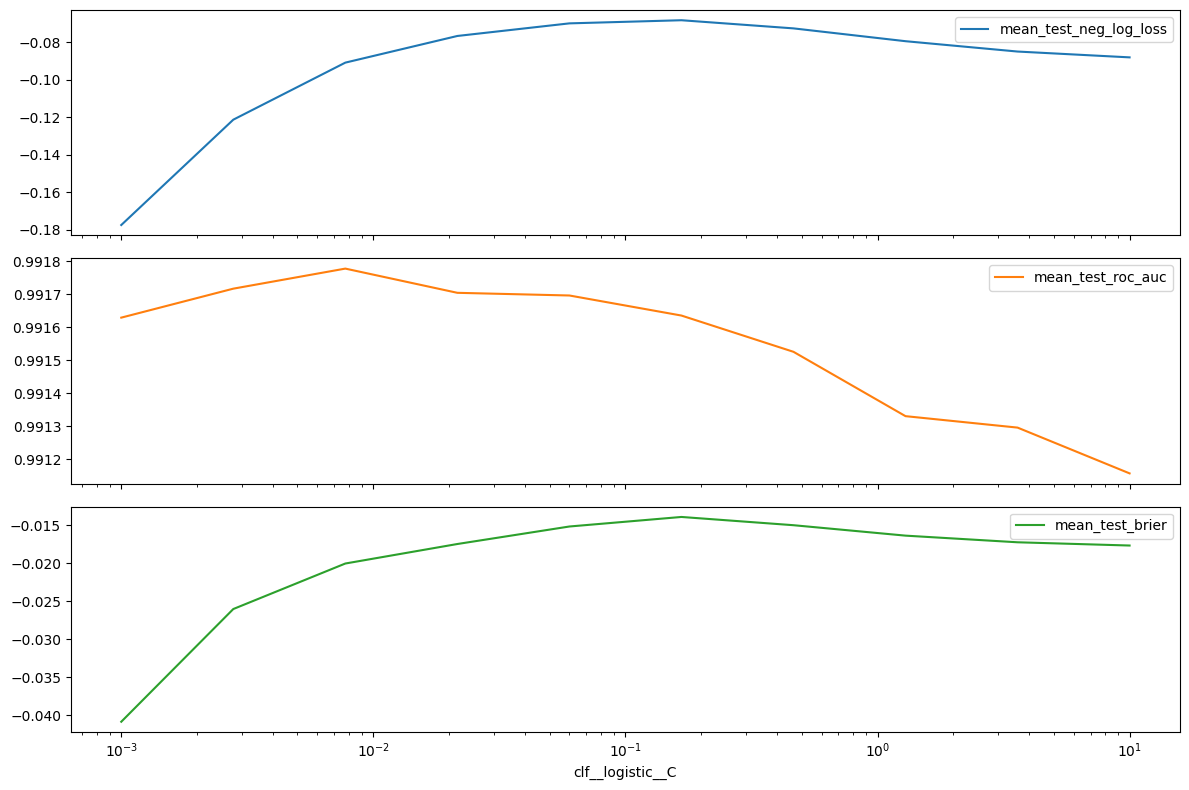

<Figure size 640x480 with 0 Axes>

In [61]:
######################################
# cross-validation results and plots #
######################################
dvc_plots = pathlib.Path("plots/")
dvc_plots.mkdir(exist_ok=True)
df_cv = print_cross_validation(cv)
axes = (
    df_cv.query("clf__logistic__penalty=='l2'")
    .query("clf=='v3.1-optb-logit'")
    .groupby("clf__logistic__C")[[f"mean_test_{scoring}" for scoring in cv.scoring]]
    .mean()
    .plot(subplots=True, logx=True, figsize=(12, 8))
)
plt.tight_layout()
if is_notebook():
    plt.show()
plt.savefig(dvc_plots / "C.png")

# cross-validation best models candidates
# Create a boolean mask indicating the duplicate rows in the 'clf' column
mask = df_cv["clf"].duplicated(keep="first")
# Invert the boolean mask to select the non-duplicate rows
df_best_models = df_cv[~mask].copy()
df_best_models.to_csv(("./data/best_models.csv"))


In [62]:
cv.best_estimator_#.predict_proba

Pipeline(steps=[('clf',
                 Pipeline(steps=[('encoder',
                                  BinningProcess(max_pvalue=0.05,
                                                 variable_names=['Temperature',
                                                                 'Humidity',
                                                                 'Light', 'CO2',
                                                                 'HumidityRatio'])),
                                 ('scaler', StandardScaler()),
                                 ('logistic',
                                  LogisticRegression(C=0.007742636826811269,
                                                     max_iter=5000,
                                                     random_state=0,
                                                     solver='saga'))]))])

In [63]:
df_best_models

,clf,clf__logistic__C,clf__logistic__max_iter,clf__logistic__penalty,clf__logistic__solver,clf__forest__max_depth,clf__forest__min_samples_leaf,clf__forest__min_samples_split,clf__forest__n_estimators,mean_test_neg_log_loss,std_test_neg_log_loss,mean_test_roc_auc,std_test_roc_auc,mean_test_brier,std_test_brier
5,v3.1-optb-logit,0.007743,5000.0,l2,saga,NaN,NaN,NaN,NaN,-0.090914,0.046115,0.991777,0.014767,-0.020051,0.013858
73,rf_classifier,NaN,NaN,NaN,NaN,10.0,4.0,10.0,200.0,-0.259740,0.284310,0.989272,0.010252,-0.028052,0.018578


## Testing less features

In [66]:
features_of_interest = [ 'Light', 'CO2', 'HumidityRatio'] 

In [67]:
clf_v3_optb_logit = sklearn.pipeline.Pipeline(
    steps=[
        (
            "encoder",
            optbinning.BinningProcess(
                variable_names=features_of_interest,
                # categorical_variables=v3_cat_features,
                max_pvalue=0.05,
            ),
        ),
        # ("removing_features_with_low_variance", VarianceThreshold(threshold=0.01)),
        ("scaler", sklearn.preprocessing.StandardScaler()),
        # ('feature_selection', feature_selector),
        (
            "logistic",
            sklearn.linear_model.LogisticRegression(random_state=0),
        ),
    ]
)
clf_v3_optb_logit.version = "v3.1-optb-logit"


clf_rf = sklearn.pipeline.Pipeline(
    steps=[
        # (
        #     "encoder",
        #     optbinning.BinningProcess(
        #         variable_names=features_covariate,
        #         # categorical_variables=v3_cat_features,
        #         max_pvalue=0.05,
        #     ),
        # ),
        # # ("removing_features_with_low_variance", VarianceThreshold(threshold=0.01)),
        # ("scaler", sklearn.preprocessing.StandardScaler()),
        # # ('feature_selection', feature_selector),
        (
            "forest",
            RandomForestClassifier(random_state=0),
        ),
    ]
)
clf_rf.version = "rf_classifier"


# grid of hyperparameters to be tested
grid = [
    {
        "clf": [clf_v3_optb_logit],
        # "clf__encoder__binning_fit_params": { [None, 0.01, 0.02, 0.03, 0.04, 0.05]},
        # "clf__logistic__C": [0.01, 0.03, 0.1, 0.3, 1],
        "clf__logistic__C": np.logspace(-3, 1, 10),  # np.linspace(0.001, 1, 10), # np.logspace(-3, 1, 5),
        "clf__logistic__solver": ["saga"],
        "clf__logistic__penalty": ["l1", "l2"],  # "elasticnet"],
        # "clf__logistic__l1_ratio": [0.0, 0.01, 0.1, 0.2, 0.5, 0.8, 1.0],
        "clf__logistic__max_iter": [5000],
    },
    {
        "clf": [clf_rf],
        "clf__forest__n_estimators": [50, 100, 200],  # Add RandomForest hyperparameters
        "clf__forest__max_depth": [None, 10, 20],
        "clf__forest__min_samples_split": [2, 5, 10],
        "clf__forest__min_samples_leaf": [1, 2, 4],
    },
]

Fitting 5 folds for each of 101 candidates, totalling 505 fits


/home/adelchiasta/venv/venv_presence_detector2/lib64/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
100 fits failed out of a total of 505.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
100 fits failed with the following error:
Traceback (most recent call last):
  File "/home/adelchiasta/venv/venv_presence_detector2/lib64/python3.11/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/adelchiasta/venv/venv_presence_detector2/lib64/python3.11/site-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/ho

clf,clf__logistic__C,clf__logistic__max_iter,clf__logistic__penalty,clf__logistic__solver,clf__forest__max_depth,clf__forest__min_samples_leaf,clf__forest__min_samples_split,clf__forest__n_estimators,mean_test_neg_log_loss,std_test_neg_log_loss,mean_test_roc_auc,std_test_roc_auc,mean_test_brier,std_test_brier
rf_classifier,nan,nan,nan,nan,10.0000,4.0000,10.0000,200.0000,-0.1714,0.1771,0.9903,0.0095,-0.0255,0.0177
rf_classifier,nan,nan,nan,nan,10.0000,2.0000,10.0000,100.0000,-0.2296,0.2796,0.9902,0.0098,-0.0258,0.0164
rf_classifier,nan,nan,nan,nan,10.0000,4.0000,10.0000,100.0000,-0.2305,0.2890,0.9902,0.0096,-0.0248,0.0167
rf_classifier,nan,nan,nan,nan,nan,4.0000,10.0000,100.0000,-0.2375,0.2861,0.9902,0.0098,-0.0250,0.0172
rf_classifier,nan,nan,nan,nan,20.0000,4.0000,10.0000,100.0000,-0.2375,0.2861,0.9902,0.0098,-0.0250,0.0172
rf_classifier,nan,nan,nan,nan,10.0000,2.0000,10.0000,50.0000,-0.2447,0.2756,0.9900,0.0100,-0.0272,0.0173
rf_classifier,nan,nan,nan,nan,10.0000,4.0000,10.0000,50.0000,-0.2600,0.2876,0.9900,0.0098,-0.0263,0.0175
rf_classifier,nan,nan,nan,nan,20.0000,4.0000,10.0000,50.0000,-0.2590,0.2870,0.9900,0.0100,-0.0270,0.0173
rf_classifier,nan,nan,nan,nan,nan,4.0000,10.0000,50.0000,-0.2590,0.2870,0.9900,0.0100,-0.0270,0.0173
rf_classifier,nan,nan,nan,nan,20.0000,2.0000,10.0000,50.0000,-0.2402,0.2781,0.9899,0.0103,-0.0262,0.0182


clf,clf__logistic__C,clf__logistic__max_iter,clf__logistic__penalty,clf__logistic__solver,clf__forest__max_depth,clf__forest__min_samples_leaf,clf__forest__min_samples_split,clf__forest__n_estimators,mean_test_neg_log_loss,std_test_neg_log_loss,mean_test_roc_auc,std_test_roc_auc,mean_test_brier,std_test_brier
rf_classifier,nan,nan,None,None,10.0000,4.0000,10.0000,200.0000,-0.1714,0.1771,0.9903,0.0095,-0.0255,0.0177
v3.1-optb-logit,0.0010,5000.0000,l1,saga,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


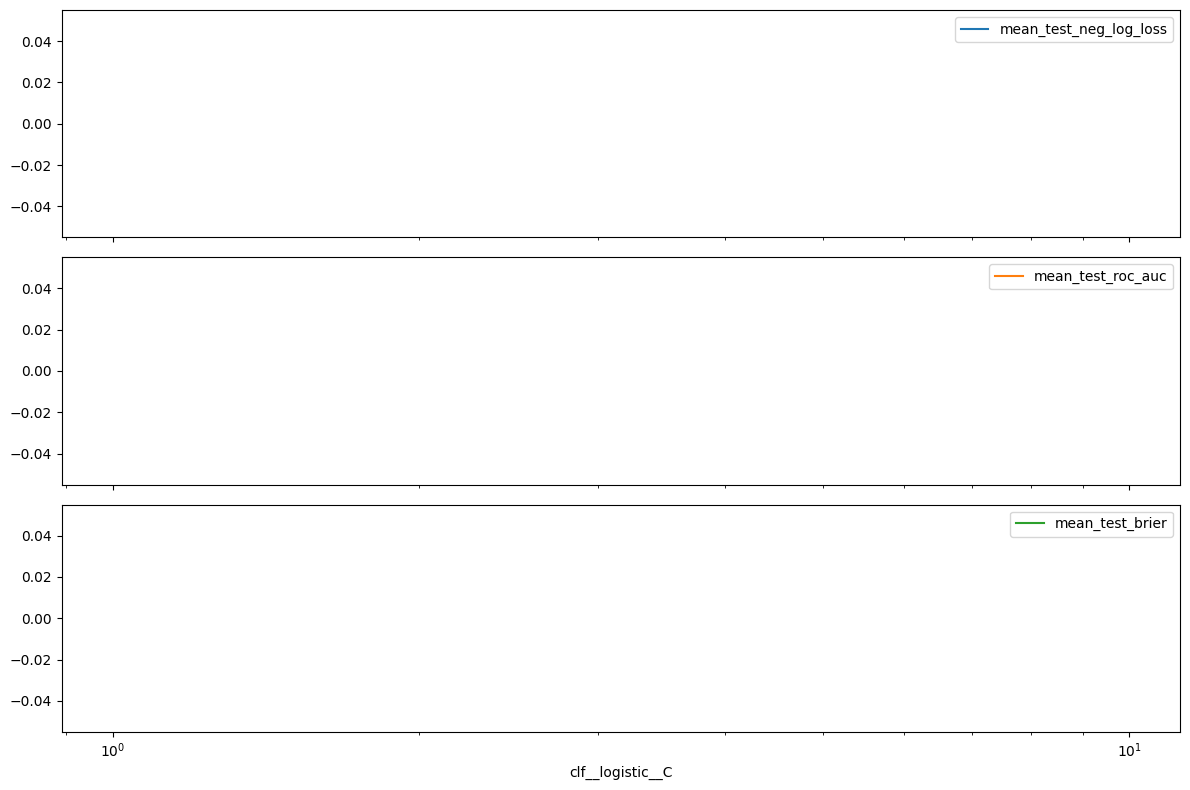

<Figure size 640x480 with 0 Axes>

In [68]:
# [ 'Light', 'CO2'] # [ 'Light', 'CO2', 'HumidityRatio'] # 
cv.fit(X_train[features_of_interest], y_train)
######################################
# cross-validation results and plots #
######################################
dvc_plots = pathlib.Path("plots/")
dvc_plots.mkdir(exist_ok=True)
df_cv = print_cross_validation(cv)
axes = (
    df_cv.query("clf__logistic__penalty=='l2'")
    .query("clf=='v3.1-optb-logit'")
    .groupby("clf__logistic__C")[[f"mean_test_{scoring}" for scoring in cv.scoring]]
    .mean()
    .plot(subplots=True, logx=True, figsize=(12, 8))
)
plt.tight_layout()
if is_notebook():
    plt.show()
plt.savefig(dvc_plots / "C.png")

# cross-validation best models candidates
# Create a boolean mask indicating the duplicate rows in the 'clf' column
mask = df_cv["clf"].duplicated(keep="first")
# Invert the boolean mask to select the non-duplicate rows
df_best_models = df_cv[~mask].copy()

# Drift check

In [20]:
X_ref = df[features_covariate].copy()
cd = TabularDrift(p_val=.05, x_ref=X_ref.to_numpy(copy=True))

/home/adelchiasta/venv/venv_notebook/lib64/python3.9/site-packages/alibi_detect/cd/tabular.py:113: UserWarning: No `categories_per_feature` dict provided so all features are assumed to be numerical. `KSDrift` will be applied to all features.
  warnings.warn('No `categories_per_feature` dict provided so all features are assumed to be numerical. '


In [22]:
preds = cd.predict(X_ref.to_numpy(copy=True))
labels = ['No!', 'Yes!']
print('Drift? {}'.format(labels[preds['data']['is_drift']]))

Drift? No!


In [23]:
!ls

attribute_information.txt  data		  datatest.txt	    old_code
classifier.ipynb	   datatest2.txt  datatraining.txt  plots


In [27]:
df2 = pd.read_csv("datatest.txt", index_col=0)
preds = cd.predict(df2[features_covariate].to_numpy(copy=True))
labels = ['No!', 'Yes!']
print('Drift? {}'.format(labels[preds['data']['is_drift']]))

Drift? Yes!


In [29]:
df_merged = pd.concat([df[features_covariate],df2[features_covariate]]).copy()

preds = cd.predict(df_merged.to_numpy(copy=True))
labels = ['No!', 'Yes!']
print('Drift? {}'.format(labels[preds['data']['is_drift']]))

Drift? Yes!
